# SABR Model Test Code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import imp
import numpy as np
import matplotlib.pyplot as plt
#import sys
#sys.path.insert(sys.path.index('')+1, 'D:/Github/PyFENG')
import pyfeng as pf
import option_models as opt

np.set_printoptions(precision=3)

## 1. Pricing using Hagan's formula (provided)

### (1) SABR for $0<\beta\le 1$

In [3]:
# Parameters
strike = np.linspace(75,125,num=25)
forward = 100
sigma = 0.2
texp = 1
vov = 0.5
rho = 0.25
beta = 1

In [4]:
# Create model
sabr_bsm = pf.SabrHagan2002(sigma, vov=vov, rho=rho, beta=beta)
#sabr_bsm.__dict__

In [5]:
# This is how you price. you can get either price or bsm_vol
price = sabr_bsm.price(strike, forward, texp)
bsm_vol = sabr_bsm.vol_smile(strike, forward, texp)

price, bsm_vol

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([0.204, 0.203, 0.202, 0.201, 0.2  , 0.2  , 0.2  , 0.2  , 0.201,
        0.202, 0.203, 0.204, 0.205, 0.206, 0.208, 0.21 , 0.211, 0.213,
        0.215, 0.217, 0.219, 0.221, 0.223, 0.225, 0.227]))

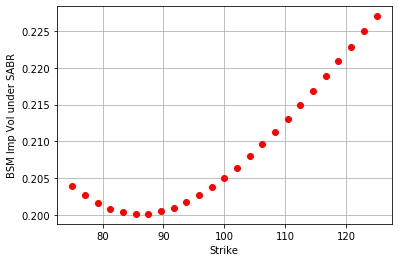

In [6]:
# volatility smile plot: try with different parameters
plt.plot(strike, bsm_vol, 'ro')
#plt.axis([0, 6, 0, 20])
plt.ylabel('BSM Imp Vol under SABR')
plt.xlabel('Strike')
plt.grid()
plt.show()

### (2) SABR for $\beta=0$

In [7]:
strike = np.linspace(75,125,num=25)
#strike = 1
forward = 100
sigma = 20
texp = 1
alpha = 0.5
rho = -0.25

In [8]:
sabr_norm = pf.SabrHagan2002(sigma, vov=vov, rho=rho, beta=0)
price = sabr_norm.price(strike, forward, texp)
nvol = sabr_norm.vol_smile(strike, forward, texp, model='norm')

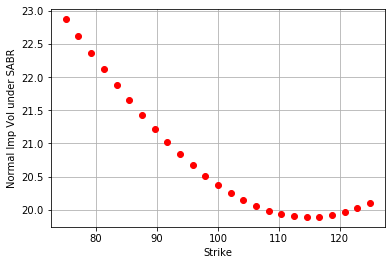

In [9]:
plt.plot(strike, nvol, 'ro')
#plt.axis([0, 6, 0, 20])
plt.ylabel('Normal Imp Vol under SABR')
plt.xlabel('Strike')
plt.grid()
plt.show()

### (3) Smile calibration to 3 options

In [10]:
strike3 = np.array([90, 100, 110])
price3 = sabr_bsm.price(strike3, forward, texp)
vol3 = sabr_bsm.vol_smile(strike3, forward, texp)

price3, vol3

(array([13.608,  8.165,  4.769]), array([0.201, 0.205, 0.213]))

In [11]:
sabr_bsm.__dict__

{'sigma': 0.2,
 'intr': 0.0,
 'divr': 0.0,
 'is_fwd': False,
 'vov': 0.5,
 'rho': 0.25,
 'beta': 1}

In [12]:
# makre sure this return the original sigma, alpha, rho
sabr_bsm.calibrate3(vol3, strike3, forward, texp, is_vol=True)

{'sigma': 0.2000000000001008,
 'vov': 0.4999999998672808,
 'rho': 0.24999999998258432}

In [13]:
# makre sure this return the original sigma, alpha, rho
sabr_bsm.calibrate3(price3, strike3, forward, texp, is_vol=False)

{'sigma': 0.19999999979636335,
 'vov': 0.5000000129299839,
 'rho': 0.2499999894054446}

## 2. Pricing under MC method

In [3]:
strike = np.linspace(75,125,num=25)
forward = 100
pf.Bsm()

TypeError: __init__() missing 1 required positional argument: 'sigma'

In [15]:
# instantiate mc model from the hagan model's parameters
print(sabr_bsm.__dict__)
sabr_bsm_mc = opt.sabr.ModelBsmMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': 0.25, 'beta': 1}


In [16]:
price_hagan = sabr_bsm.price(strike, forward, texp)
price_mc = sabr_bsm_mc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([28.021, 26.098, 24.216, 22.391, 20.631, 18.948, 17.342, 15.821,
        14.389, 13.047, 11.801, 10.649,  9.591,  8.625,  7.748,  6.956,
         6.242,  5.598,  5.023,  4.504,  4.037,  3.623,  3.257,  2.926,
         2.63 ]))

In [17]:
sabr_bsm_mc.bsm_vol(strike, forward, texp, sigma)

array([0.331, 0.316, 0.303, 0.291, 0.281, 0.272, 0.265, 0.259, 0.253,
       0.249, 0.246, 0.243, 0.241, 0.239, 0.239, 0.238, 0.238, 0.238,
       0.238, 0.239, 0.239, 0.24 , 0.241, 0.242, 0.243])

Repeat the same for beta = 0

In [18]:
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_mc = opt.sabr.ModelNormalMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


In [19]:
price_hagan = sabr_norm.price(strike, forward, texp)
price_mc = sabr_norm_mc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([26.591, 24.753, 22.952, 21.192, 19.479, 17.818, 16.215, 14.675,
        13.206, 11.811, 10.497,  9.268,  8.129,  7.08 ,  6.125,  5.262,
         4.49 ,  3.807,  3.207,  2.686,  2.237,  1.854,  1.53 ,  1.257,
         1.03 ]),
 array([24.449, 22.653, 20.898, 19.189, 17.538, 15.945, 14.422, 12.974,
        11.598, 10.302,  9.091,  7.969,  6.942,  6.009,  5.165,  4.411,
         3.743,  3.153,  2.637,  2.191,  1.806,  1.485,  1.218,  0.996,
         0.81 ]))

In [20]:
sabr_norm_mc.norm_vol(strike, forward, texp, sigma)

array([   nan,    nan,  9.939, 13.038, 14.35 , 15.176, 15.775, 16.234,
       16.577, 16.844, 17.059, 17.239, 17.402, 17.55 , 17.679, 17.805,
       17.924, 18.031, 18.131, 18.227, 18.317, 18.427, 18.558, 18.702,
       18.839])

## 3. Pricing under conditional MC method

In [21]:
strike = np.linspace(75,125,num=25)
forward = 100

In [22]:
# instantiate mc model from the hagan model's parameters
print(sabr_bsm.__dict__)
sabr_bsm_cmc = opt.sabr.ModelBsmCondMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': 0.25, 'beta': 1}


In [23]:
price_hagan = sabr_bsm.price(strike, forward, texp)
price_mc = sabr_bsm_cmc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

{'sigma': 0.20625774934981253, 'intr': 0, 'divr': 0, 'is_fwd': False}


(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([25.506, 23.656, 21.862, 20.131, 18.469, 16.882, 15.374, 13.949,
        12.61 , 11.358, 10.193,  9.116,  8.125,  7.216,  6.388,  5.637,
         4.959,  4.349,  3.803,  3.316,  2.884,  2.501,  2.163,  1.867,
         1.607]))

Repeat the same for beta = 0

In [24]:
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_cmc = opt.sabr.ModelNormalCondMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


In [25]:
price_hagan = sabr_norm.price(strike, forward, texp)
price_mc = sabr_norm_cmc.price(strike, forward, texp)
    
# make sure the two prices are similar
price_hagan, price_mc

(array([26.591, 24.753, 22.952, 21.192, 19.479, 17.818, 16.215, 14.675,
        13.206, 11.811, 10.497,  9.268,  8.129,  7.08 ,  6.125,  5.262,
         4.49 ,  3.807,  3.207,  2.686,  2.237,  1.854,  1.53 ,  1.257,
         1.03 ]),
 array([26.15 , 24.322, 22.539, 20.807, 19.13 , 17.514, 15.962, 14.481,
        13.074, 11.743, 10.493,  9.325,  8.241,  7.24 ,  6.323,  5.488,
         4.733,  4.055,  3.452,  2.918,  2.449,  2.042,  1.69 ,  1.388,
         1.131]))

## Compare the MC variance between brute-force MC and conditional MC
For this, you should not use the random number seed